### EDA

In [1]:
import pandas as pd
import numpy as np
import re
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

W0605 16:11:01.783000 8968 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [ ]:
# Caricamento del dataset, considerando solo raw review All Beauty
data = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
print(data["full"][0])

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}


In [ ]:

df = data["full"].to_pandas()

# STEP 1: Uniformare i valori nulli scritti come stringhe
null_equivalents = ["^NaN$", "^na$", "^NA$", "^null$", "^None$", "^N/A$", "^n/a$", "^\s*$"]
df.replace(to_replace=null_equivalents, value=np.nan, regex=True, inplace=True)

# STEP 2: Controllare tipi delle colonne
print("INFO:")
print(df.info())
print("\n")

# STEP 3: Contare i valori nulli reali dopo la sostituzione
print("VALORI MANCANTI PER COLONNA:")
print(df.isnull().sum())
print("\n")

# STEP 4: Visualizzare un campione
print("ESEMPI DI RIGHE CON NULL:")
print(df[df.isnull().any(axis=1)].head(10))


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701358 non-null  object 
 2   text               700690 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB
None


VALORI MANCANTI PER COLONNA:
rating                 0
title                170
text                 838
images                 0
asin                   0
parent_asin            0
user_id                0
timestamp   

In [ ]:
# Filtra solo le righe con text e rating validi
df_clean = df[["text", "rating"]].dropna(subset=["text", "rating"])

# Resetta gli indici per comodità
df_clean = df_clean.reset_index(drop=True)

# Controllo
print("Shape finale:", df_clean.shape)
print(df_clean.head())


Shape finale: (700690, 2)
                                                text  rating
0  This spray is really nice. It smells really go...     5.0
1  This product does what I need it to do, I just...     4.0
2                          Smells good, feels great!     5.0
3                                     Felt synthetic     1.0
4                                            Love it     5.0


In [ ]:
df_clean["text_len"] = df_clean["text"].apply(lambda x: len(str(x).split()))
# Imposta lo stile grafico
sns.set(style="whitegrid")

C:\Users\rosac\AppData\Local\Temp\ipykernel_6732\511397318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df_clean, palette="viridis")


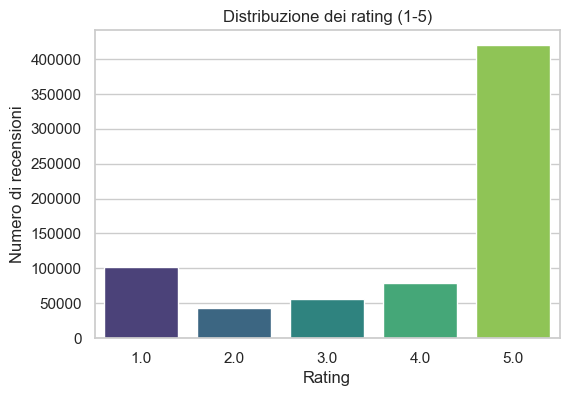

In [ ]:
# 1. Distribuzione dei rating
plt.figure(figsize=(6, 4))
sns.countplot(x="rating", data=df_clean, palette="viridis")
plt.title("Distribuzione dei rating (1-5)")
plt.xlabel("Rating")
plt.ylabel("Numero di recensioni")
plt.show()

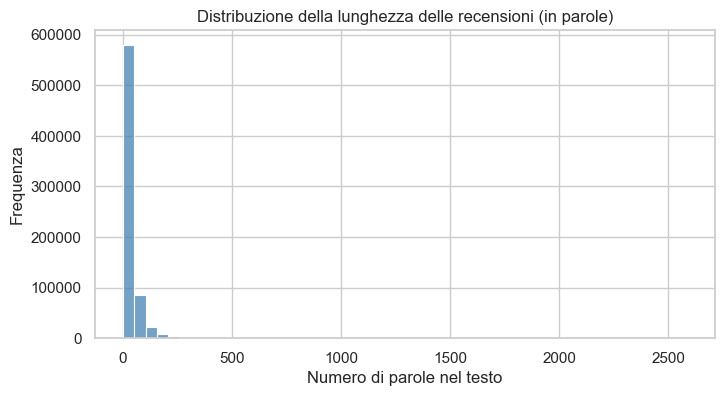

In [ ]:

# 2. Istogramma della lunghezza delle recensioni
plt.figure(figsize=(8, 4))
sns.histplot(df_clean["text_len"], bins=50, kde=False, color="steelblue")
plt.title("Distribuzione della lunghezza delle recensioni (in parole)")
plt.xlabel("Numero di parole nel testo")
plt.ylabel("Frequenza")
plt.show()

C:\Users\rosac\AppData\Local\Temp\ipykernel_6732\2563711040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="text_len", data=df_clean, palette="coolwarm")


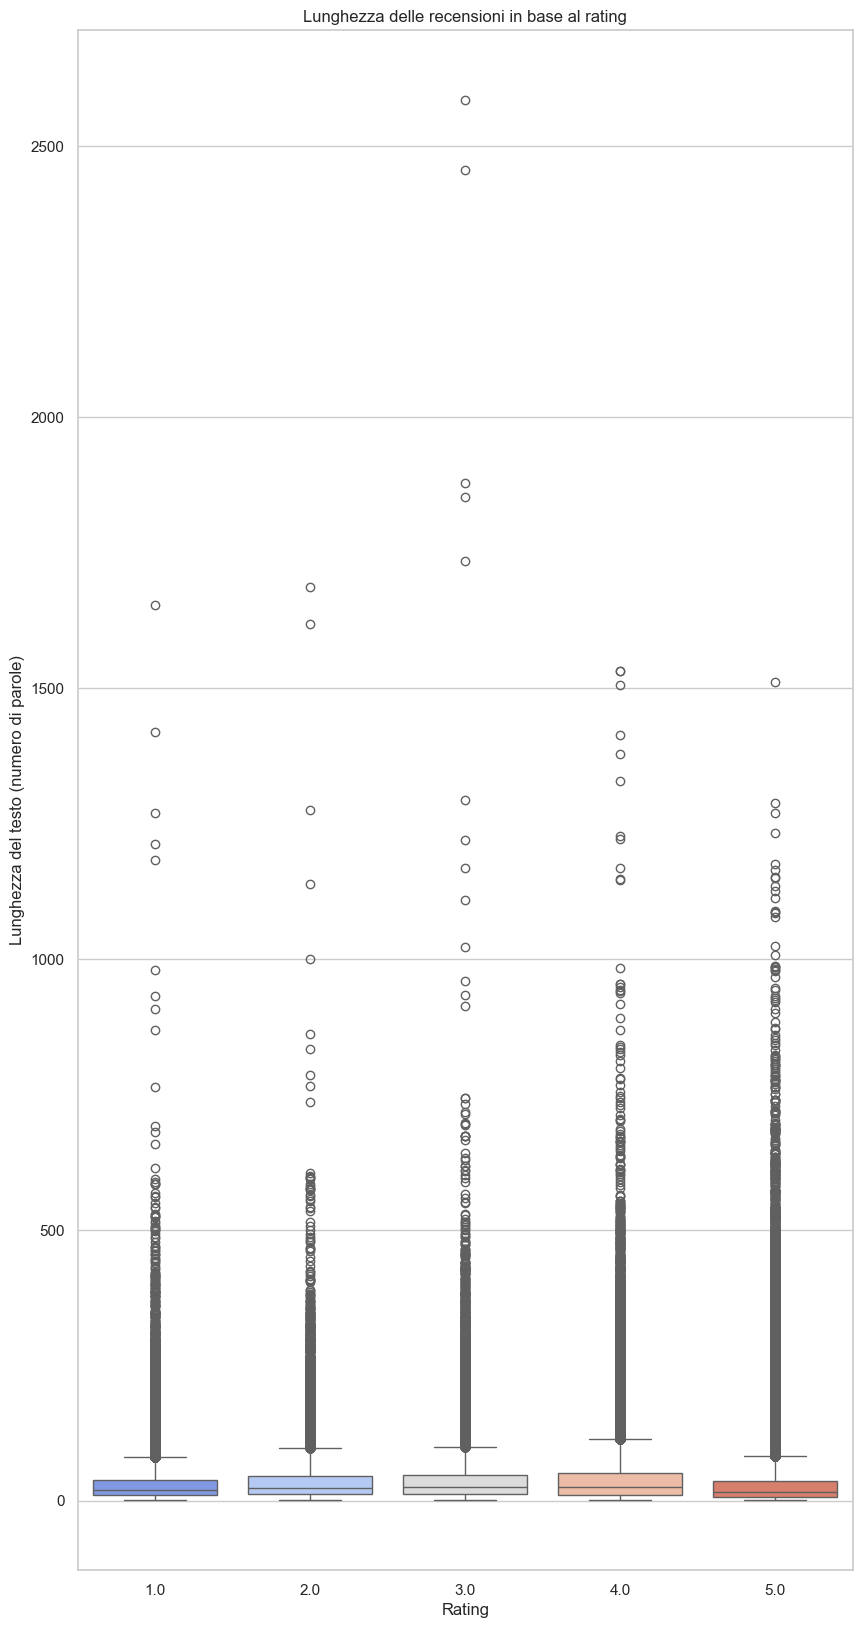

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(x="rating", y="text_len", data=df_clean, palette="coolwarm")
plt.title("Lunghezza delle recensioni in base al rating")
plt.xlabel("Rating")
plt.ylabel("Lunghezza del testo (numero di parole)")
plt.show()

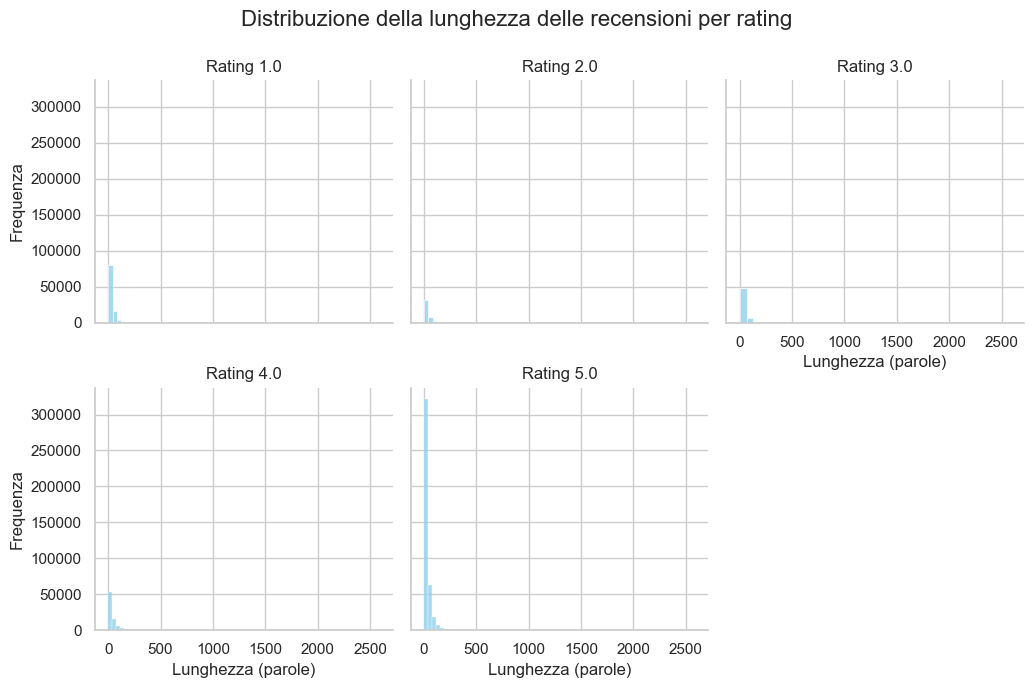

In [ ]:

# FacetGrid: istogramma della lunghezza per ogni rating
g = sns.FacetGrid(df_clean, col="rating", col_wrap=3, height=3.5, sharex=True, sharey=True)
g.map(sns.histplot, "text_len", bins=40, color="skyblue")
g.set_titles("Rating {col_name}")
g.set_axis_labels("Lunghezza (parole)", "Frequenza")
g.fig.suptitle("Distribuzione della lunghezza delle recensioni per rating", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


| ⭐ Rating | 🎨 Colore   | Codice   |
|----------|-------------|----------|
| 1        | 🔴 rosso     | `"red"`   |
| 2        | 🟠 arancione | `"orange"`|
| 3        | ⚪ grigio    | `"gray"`  |
| 4        | 🔵 blu       | `"blue"`  |
| 5        | 🟢 verde     | `"green"` |


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rosac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


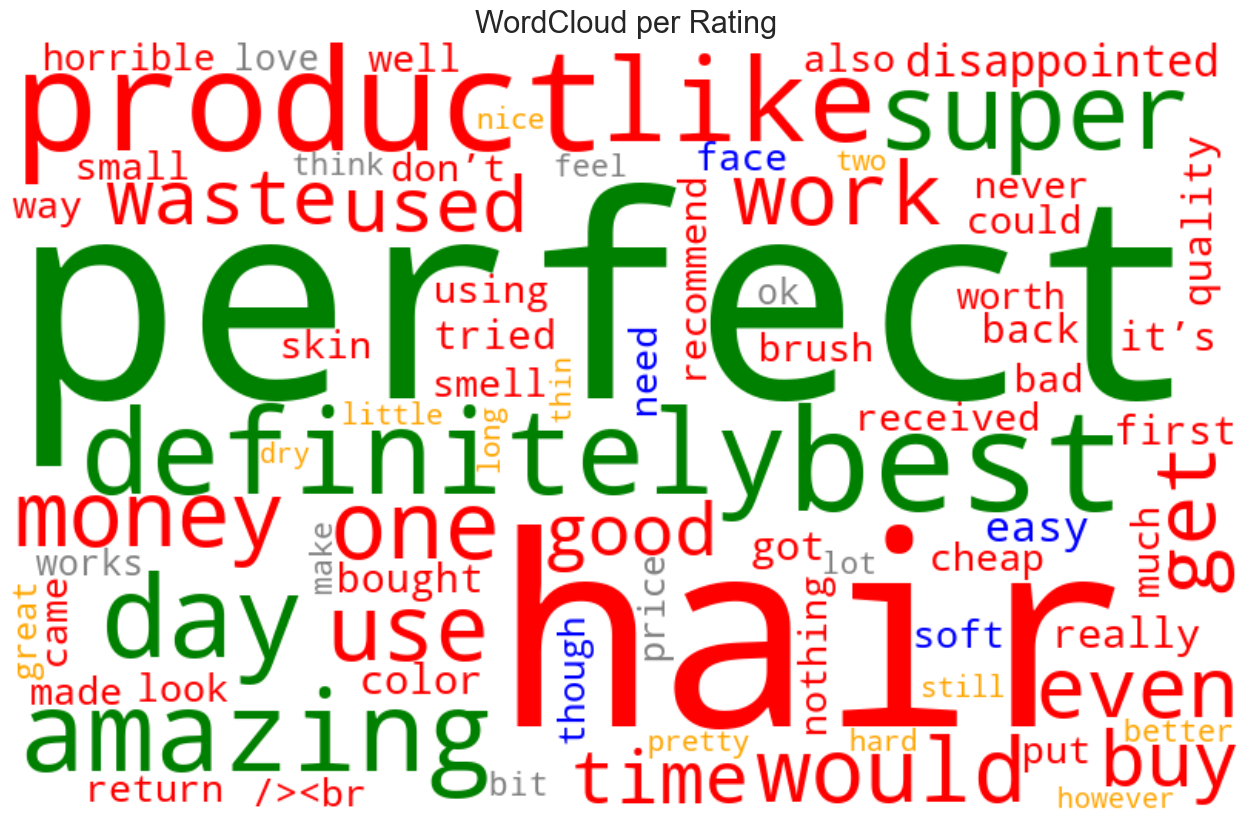

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk
import random

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Colori rating
rating_colors = {
    1: "red",
    2: "orange",
    3: "gray",
    4: "blue",
    5: "green"
}

# Estrai parole per rating
def extract_rating_words(df, rating):
    texts = df[df["rating"] == rating]["text"].dropna().astype(str)
    words = []
    for text in texts:
        for word in text.lower().split():
            word = word.strip(".,!?\"'()[]")
            if word not in stop_words and len(word) > 1:
                words.append(word)
    return words

# Costruisci word → (frequenza, rating)
word_rating_freq = {}
for rating in sorted(df_clean["rating"].unique()):
    words = extract_rating_words(df_clean, rating)
    freq = Counter(words).most_common(50)
    for word, count in freq:
        if word not in word_rating_freq:
            word_rating_freq[word] = (count, rating)

# Color function per rating
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    _, rating = word_rating_freq.get(word, (1, 3))
    return rating_colors.get(rating, "black")

# Frequenze per la WordCloud
frequencies = {word: freq for word, (freq, _) in word_rating_freq.items()}

# Crea WordCloud
wc = WordCloud(width=800, height=500, background_color="white").generate_from_frequencies(frequencies)
wc.recolor(color_func=color_func)


# Disegna WordCloud + Etichette
plt.figure(figsize=(16, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")


plt.title("WordCloud per Rating", fontsize=22)
plt.show()


In [ ]:
from textblob import TextBlob

# Calcola la polarità per ogni recensione (range da -1 a +1)
df_clean["polarity"] = df_clean["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


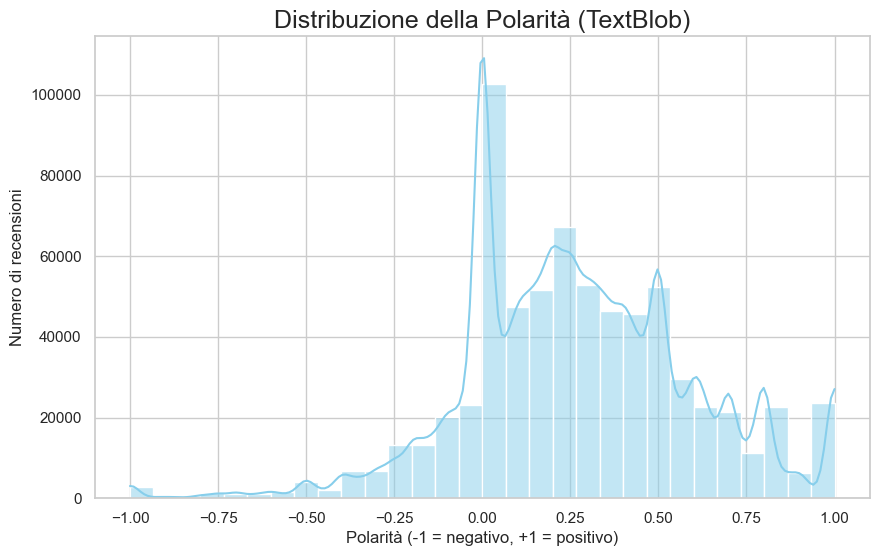

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_clean["polarity"], bins=30, kde=True, color="skyblue")
plt.title("Distribuzione della Polarità (TextBlob)", fontsize=18)
plt.xlabel("Polarità (-1 = negativo, +1 = positivo)")
plt.ylabel("Numero di recensioni")
plt.grid(True)
plt.show()

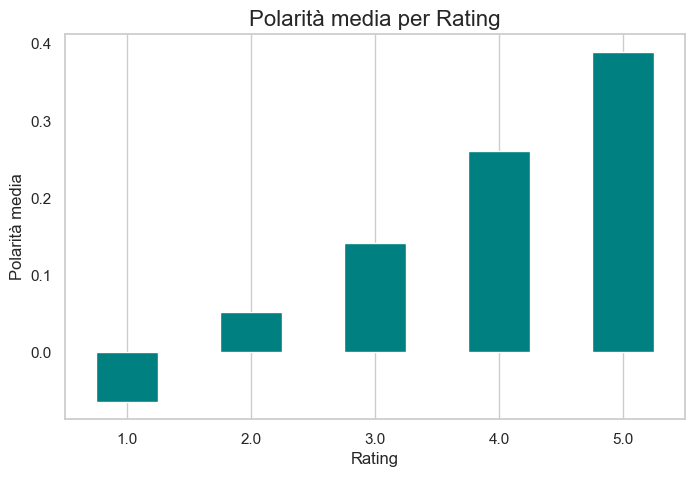

In [ ]:
# Calcola media della polarità per ogni rating
mean_polarity = df_clean.groupby("rating")["polarity"].mean()

# Visualizzazione
plt.figure(figsize=(8, 5))
mean_polarity.plot(kind="bar", color="teal")
plt.title("Polarità media per Rating", fontsize=16)
plt.xlabel("Rating")
plt.ylabel("Polarità media")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


In [ ]:
anomale_rating_5 = df_clean[(df_clean["rating"] == 5) & (df_clean["polarity"] < 0)]
anomale_rating_1 = df_clean[(df_clean["rating"] == 1) & (df_clean["polarity"] > 0)]
anomale = pd.concat([anomale_rating_1, anomale_rating_5], ignore_index=True)
anomale[["rating", "polarity", "text"]].sort_values(by="polarity")



,rating,polarity,text
47741,5.0,-1.0,Es extremadamente excelente me ha hidratado mi...
43766,5.0,-1.0,"Me gusta la textura que le da a mi cara, prote..."
43670,5.0,-1.0,I use this as a bug repellent. It's a lotion s...
39488,5.0,-1.0,The stand it the worst it don’t stay still in ...
36829,5.0,-1.0,It works on my terrible rash.
...,...,...,...
1520,1.0,1.0,"It worked great, just as advertised, for about..."
25113,1.0,1.0,The design is good but this product doesn't wo...
33492,1.0,1.0,"Got product, and tried to use with my wife's ""..."
9026,1.0,1.0,Bought this for a birthday party and it was pe...


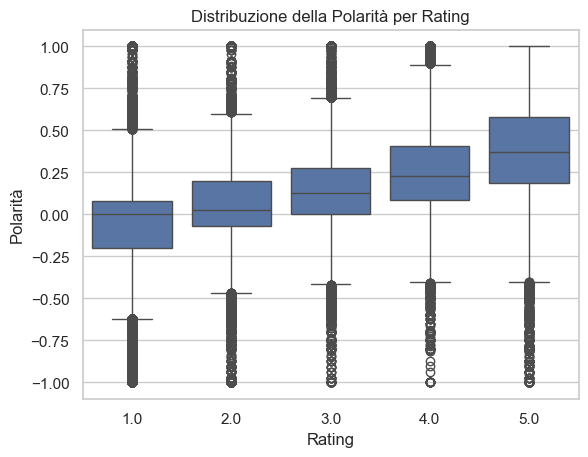

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che 'df_clean' contenga le colonne 'rating' e 'polarity'
sns.boxplot(data=df_clean, x="rating", y="polarity")
plt.title("Distribuzione della Polarità per Rating")
plt.xlabel("Rating")
plt.ylabel("Polarità")
plt.show()

In [ ]:
# Calcola Q1, Q3, IQR, e i baffi per ogni rating
q = df_clean.groupby("rating")["polarity"].quantile([0.25, 0.75]).unstack()
q.columns = ["Q1", "Q3"]
q["IQR"] = q["Q3"] - q["Q1"]
q["lower_whisker"] = q["Q1"] - 1.5 * q["IQR"]
q["upper_whisker"] = q["Q3"] + 1.5 * q["IQR"]

# Converti in dizionari per accesso veloce
lw = q["lower_whisker"].to_dict()
uw = q["upper_whisker"].to_dict()

# Funzione per etichettare incoerenza secondo i baffi
def is_incoherent(row):
    r, p = row["rating"], row["polarity"]
    if r == 1 and p > uw[1]:
        return True
    elif r == 2 and p > uw[2]:
        return True
    elif r == 3 and not (lw[3] <= p <= uw[3]):
        return True
    elif r == 4 and p < lw[4]:
        return True
    elif r == 5 and p < lw[5]:
        return True
    return False

# Applica la funzione
df_clean["incoerente"] = df_clean.apply(is_incoherent, axis=1)

# Estrai recensioni incoerenti
anomale = df_clean[df_clean["incoerente"] == True].copy()

# Visualizza
anomale[["rating", "polarity", "text"]].sort_values(by="rating")


,rating,polarity,text
700131,1.0,0.800000,"Lasted a week, wires came out. Ended up going ..."
223078,1.0,0.525000,All the wigs and buns that I have bought wher...
221635,1.0,0.750000,This product dies not give the results that it...
220905,1.0,0.566667,"I loved how it worked on my hair, but I can't..."
220142,1.0,0.800000,This trimmer was great for the two months it w...
...,...,...,...
584095,5.0,-0.500000,Dont buy sucky sorry took out and replaced the...
583738,5.0,-0.500000,too expensive
254874,5.0,-0.500000,Works to sooth my condition but still expensiv...
208177,5.0,-0.500000,I am sooooo sad Olay discontinued this soap.
